### How to push to github
##### Write the following in the git terminal:
##### git add *
##### git commit -m "Write the changes in the file that were done here"
##### git push

In [267]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.special import kn
from scipy.integrate import quad
import csv

%run FreezeOutFunctions.ipynb
%run CrossSectionFunctions.ipynb

In [269]:
with open('Gstar.csv', 'r') as f:
    Gstarreader = csv.reader(f)
    Gstardata = {float(row[0]): float(row[1]) for row in Gstarreader}

with open('GstarS.csv', 'r') as f:
    GstarSreader = csv.reader(f)
    GstarSdata = {float(row[0]): float(row[1]) for row in GstarSreader}

<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\s'
C:\Users\press\AppData\Local\Temp\ipykernel_636\3503375289.py:25: SyntaxWarning: invalid escape sequence '\s'
  plt.title('Log plot of Y(x) for different $\sigma$ values')
C:\Users\press\AppData\Local\Temp\ipykernel_636\4065862426.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  return (1 / (8 * m**4 * T * kn(2, m / T))) * integral_result
C:\Users\press\AppData\Local\Temp\ipykernel_636\4065862426.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  return (1 / (8 * m**4 * T * kn(2, m / T))) * integral_result


Frozen-out Y(x) for Sigma_SC_NeutralPion = 1e-28: 9.999995023677388e+24
Frozen-out Y(x) for Sigma_SC_NeutralKaon = 9.999999999999998e-21: 2.0139539634767264e+23


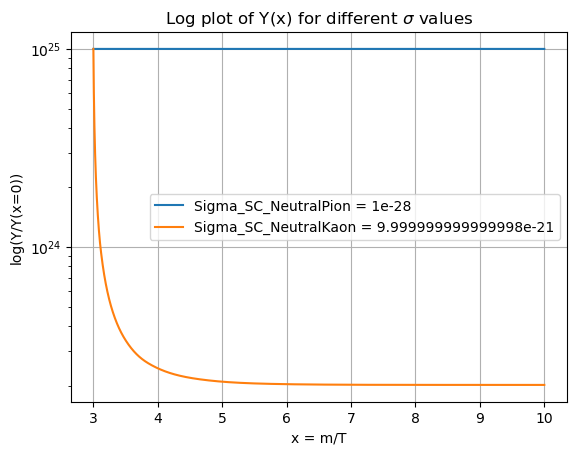

In [271]:
Y0 = [1e25]  
x_min = 3  
x_max = 10 
x_span = (x_min, x_max)
x_eval = np.linspace(x_min, x_max, 500000)

sigma_values = [Sigma_SC_NeutralPion, Sigma_SC_NeutralKaon]

for sigma_value in sigma_values:
    sigma_name = get_variable_name(sigma_value, globals())
    sol = solve_ivp(lambda x, Y: dYdx(x, Y, sigma_value), x_span, Y0, t_eval=x_eval)
        
    # Number of frozen-out dm particles
    Y_frozen = sol.y[0, -1]
    print(f'Frozen-out Y(x) for {sigma_name} = {sigma_value}: {Y_frozen}')
    
    plt.plot(sol.t, sol.y[0], label=f'{sigma_name} = {sigma_value}')

    
# Plot configurations
plt.yscale('log')  
#plt.xscale('log')  
plt.xlabel('x = m/T')
plt.ylabel('log(Y/Y(x=0))')
plt.title('Log plot of Y(x) for different $\sigma$ values')
plt.legend()
plt.grid(True)
#plt.savefig('DifferentSigmaSValues.png', facecolor='w')

plt.show()